Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________
11493376/11490434 [==============================] - 0s 0us/step
epoch:0  d_loss:0.7053  g_loss:0.6912
epoch:1  d_loss:0.4626  g_loss:0.3284
epoch:2  d_loss:0.5723  g_loss:0.1035
epoch:3  d_loss:0.6589  g_loss:0.0859
epoch:4  d_loss:0.5757  g_loss:0.1685
epoch:5  d_loss:0.5078  g_loss:0.4268
epoch:6  d_loss:0.4876  g_loss:0.7022
epoch:7  d_loss:0.5093  g_loss:0.8728
epoch:8 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


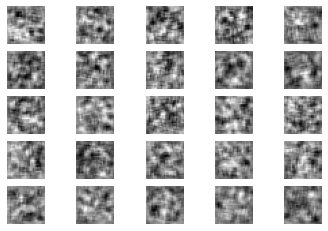

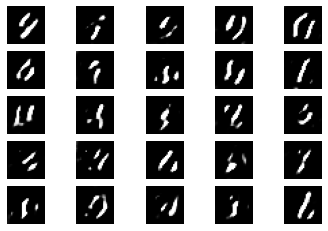

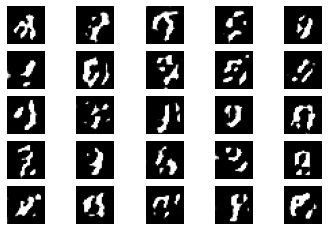

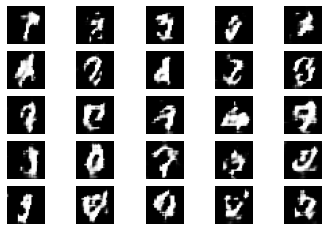

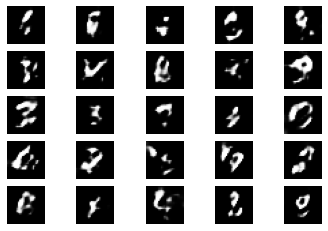

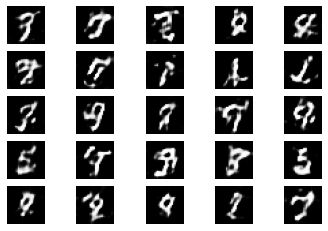

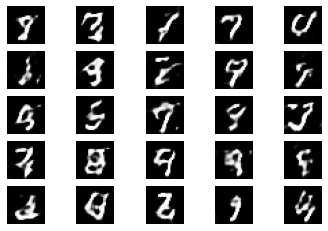

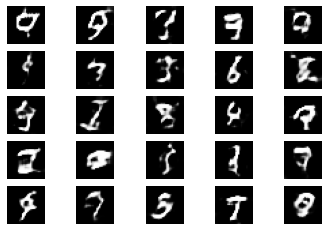

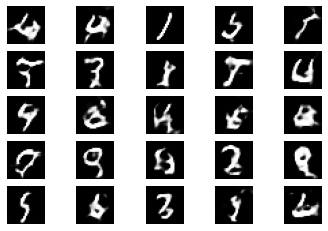

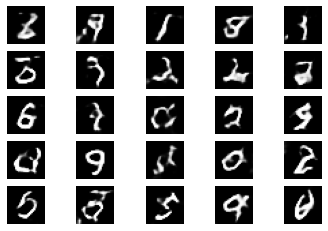

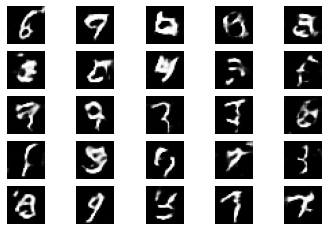

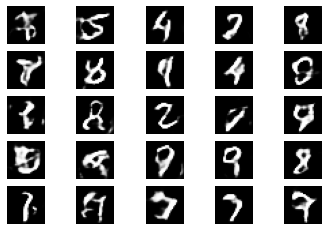

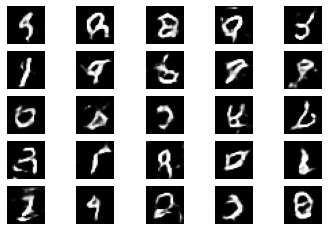

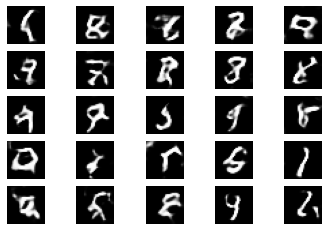

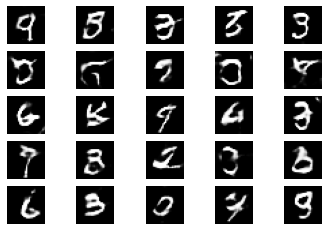

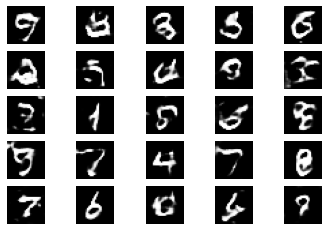

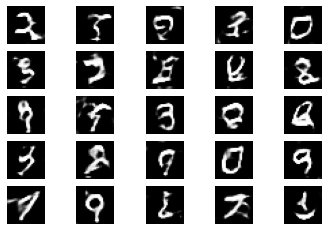

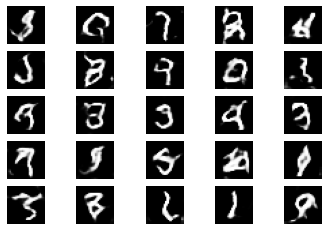

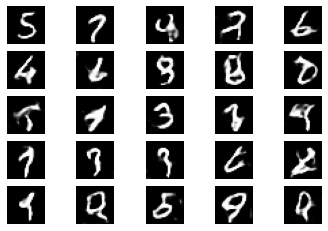

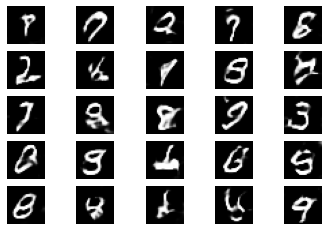

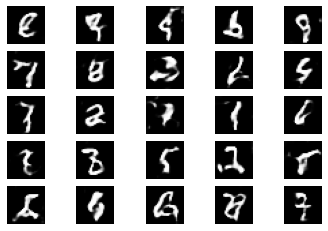

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

#이미지가 저장될 폴더가 없다면 만듭니다.
import os
if not os.path.exists("./gan_images"):
    os.makedirs("./gan_images")

np.random.seed(3)
tf.random.set_seed(3)

#생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
# 128: 임의로 만든 노드의 수
# 주의: 7*7 손글씨 이미지의 크기는 28*28인데, UpSampling2D 함수(이미지 크기 가로 세로를 2배로 늘려주는 함수)를 두번 쓰므로, 7*7
# input dim: 100차원 크기의 램덤 벡터(적절한 임의의 수)
# LakyReLU: x값이 음수(면 ReLu는 0이라서 소실 됨)라도 값을 내오게끔 하기 위하여
generator.add(BatchNormalization())
# 배치 정규화: 데이터의 평균이 0, 분산이 1이 되도록 재배치
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
# 이미지 크기 가로 세로를 2배로 늘려줌
generator.add(Conv2D(64, kernel_size=5, padding='same'))
# kernel = 커널, 마스크, 필터
# size 때문에 패딩
generator.add(BatchNormalization())
# size 변화 있으니 다시 배치 정규화
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))
# 출력층
# 5*5로 빈칸 생기니까 패딩, 그리고 활성화 함수는 쌍곡선 탄젠트 함수

#판별자 모델을 만듭니다.
# 진짜인지 가짜인지 판별한다는 것을 기억(강아지와 고양이 분류 CNN)
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
# 커널, 필터, 마스크 사이즈는 5*5, 
# strides는 n칸씩 움직이라는 뜻, 특징값 뽑는 것
# (28,28,1)은 NMIST 이미지 shape, 단 1은 흑백, 3은 컬러(RGB 채널)
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
# 30% drop
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
# 1차원 배열로 만들어줌
discriminator.add(Dense(1, activation='sigmoid'))
# 출력층, 가짜(0), 진짜(1)를 판별하므로 이진분류 시그모이드 함수를 사용
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
# 오차는 교차엔트로피, 함수는 아담
discriminator.trainable = False
# 반드시 기억: 훈련시키지 않는다!
# 가중치는 있어야 하니까 학습 절차는 그대로 가지만, 절대 훈련은 없다!

#생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,)) # 1차원 배열
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

#신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):
  # MNIST 데이터 불러오기
  # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape
  (X_train, _), (_, _) = mnist.load_data()  
  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트과정은 필요없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  
  # 픽셀값은 0에서 255사이의 값입니다. 
  # 이전에 255로 나누어 줄때는 이를 0~1사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  # 탄젠트 함수 때문임
  

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          # randint 랜덤하게 정수만, a부터 b까지 숫자 중 하나만 랜덤하게 선택하는 과정을 c번 반복해
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          #가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          # 정규화: 정규 분포로 다 평균으로 회귀됨
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          #판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          # 0.5가 평균
          g_loss = gan.train_on_batch(noise, true)
          # True: 1

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 본 장의 주요 내용과 관련이 없어
        # 소스코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("gan_images/gan_mnist_%d.png" % i)

gan_train(4001, 32, 200)  #4000번 반복되고(+1을 해 주는 것에 주의), 배치 사이즈는 32,  200번 마다 결과가 저장되게 하였습니다.
